Предварительная подготовка, требуется только для Google Colab

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Создаём папку проекта, если она отсутствует

In [116]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

PATH_ANS = 'keras_autoencoder'

if not os.path.exists(PATH_ANS):
    os.mkdir(PATH_ANS)

Импорт библиотек



In [117]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

from keras import optimizers, losses

from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
import keras.backend as K
from keras.layers import Lambda

In [118]:
R_STATE = 17

### Шаг 1: задаём исходные данные

Зададим частоту дискретизации и количество точек, из которых будет состоять один обучающий образец. А также параметры используемого АЦП: постоянное смещение, разрядность и отношение "сигнал/шум" (SNR).

In [119]:
# fft size
N = 1024 

# sample freq
Fs = 3e9

# time step (sec)
tau = 1/Fs

# size of fft window
window_size = tau * N

# adc parameters
adc_shift = 512
adc_digits = 10
adc_snr = 38 # db

# 0.999 coef to avoid overflow adc
adc_scale = 2** (adc_digits - 1) * 0.999

print(f'Размер окна БПФ {N} точек и {round(tau * 1e9,2)} нс \nЧастота дискретизации {Fs} ГГц \nШаг между отсчётами {round(window_size * 1e9,2)} нс \n')
print(f'Постоянный сдвиг АЦП {adc_shift} отсчётов\nРазрядность АЦП равна {adc_digits}\nШкала АЦП от -{adc_scale} до {adc_scale}\nSNR = {adc_snr} дБ')

Размер окна БПФ 1024 точек и 0.33 нс 
Частота дискретизации 3000000000.0 ГГц 
Шаг между отсчётами 341.33 нс 

Постоянный сдвиг АЦП 512 отсчётов
Разрядность АЦП равна 10
Шкала АЦП от -511.488 до 511.488
SNR = 38 дБ


### Шаг 2: создаём тренировочный датасет

Необходимо создать массив синусоидальных сигналов со случайными значениями амплитуды, частоты и начальной фазы. Масштабировать их на шкалу 0...1024. Это будет выходной обучающий массив.

Полученные сигналы смешать с гауссовым шумом и получить входной обучающий массив.

Напишем функции.
Первая будет возвращать синусоидальный сигнал и смесь сигнала с гауссовым шум по заданным параметрам амплитуды, частоты и начальной фазы. 
Вторая отрисует красивый график.

In [120]:
def make_signal (t_size, t_step, amp=0, f=1e6, phi=0, shift=0, scale=1, noise_level = -40):
  ##########################
  # t_size - x-axis length
  # t_step - x-axis step
  # amp - amplitude in db
  # f - frequency in Hz
  # phi - initil phase in radians
  # shift - mean zero shift level in adc ponits
  # scale - rounded data in different adc scale
  # noise_level - std for gaussian noise in db
  ##########################

  amp_vlt = 10 ** (amp / 20)
  x = np.arange(0, t_size, t_step)
  y = amp_vlt * scale * np.cos(2 * np.pi * f * x + phi) + shift

  noise_vlt = 10 ** (noise_level / 20)
  mean_noise = 0
  noise = np.random.normal(mean_noise, np.sqrt(noise_vlt), int(t_size/t_step))

  y_noise = y + noise

  return x, np.round(y), np.round(y_noise)

def make_plot(x, y, noised=0, scale=512):
  plt.plot(x, y)
  if noised == 0:
    plt.title("Clean Signal")
  else:
    plt.title("Noised signal")
  plt.xlabel('time(ns)')
  plt.ylabel('adc_amplitude')
  plt.grid(True, which='both')
  plt.axhline(scale, color='r')
  plt.show()

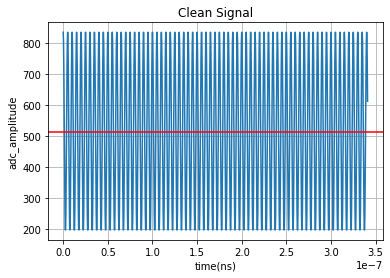

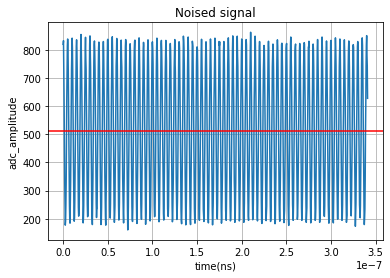

In [121]:
freq = 6200e6 #hz
amp = -4 #db
snr = -10 # db

noise_lvl = amp + adc_snr - snr

x, y, y_noise = make_signal(t_size=window_size, 
                            t_step=tau, 
                            amp=amp, 
                            f=freq, 
                            shift=adc_shift,
                            scale=adc_scale,
                            noise_level=noise_lvl)
make_plot(x,y)
make_plot(x,y_noise, noised=1)

Посмотрим на спектр наших сигналов. Нулевой отсчёт соответствует постояннной составляющей `adc_shift=512`

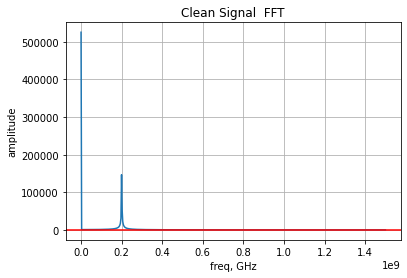

Частота сигнала незашумлённого сигнала равна 199.22 МГц


In [122]:
y_fft = np.round(np.abs(np.fft.fft(y, N)))
x_fft = np.linspace(0, int(Fs/2), int(N/2))

def make_plot_fft(x, y, noised=0):
  plt.plot(x, y)
  if noised == 0:
    plt.title("Clean Signal  FFT")
  else:
    plt.title("Noised signal FFT")
  plt.xlabel('freq, GHz')
  plt.ylabel('amplitude')
  plt.grid(True, which='both')
  plt.axhline(0, color='r')
  plt.show()

make_plot_fft(x_fft, y_fft[0:512])

from scipy.signal import argrelextrema
maxInd = argrelextrema(y_fft, np.greater)

print(f'Частота сигнала незашумлённого сигнала равна {np.round(maxInd[0][0] * Fs/N *1e-6, 2)} МГц')

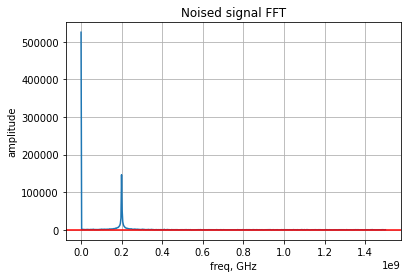

Частота сигнала зашумлённого сигнала равна 199.22 МГц


In [123]:
y_fft_n = np.round(np.abs(np.fft.fft(y_noise, N)))

make_plot_fft(x_fft, y_fft_n[0:512], noised=1)

from scipy.signal import argrelextrema
maxInd = argrelextrema(y_fft, np.greater)

print(f'Частота сигнала зашумлённого сигнала равна {np.round(maxInd[0][0] * Fs/N *1e-6, 2)} МГц')

Создадим тренировачный датасет на 10000 элементов из чистого и зашумлённого сигналов при помощи написанной ранее функции `make_signal`. Амплитуду, частоту и SNR зададим случайными величинами.

In [124]:
def make_dataset (n_sample):
  
  amp = np.random.randint(-45,0,n_sample)
  freq = np.random.randint(100,18000,n_sample) * 1e6
  snr = np.random.randint(-30,30,n_sample)
  
  noise_lvl = amp + adc_snr - snr

  y_train, x_train = np.zeros((n_sample, N)), np.zeros((n_sample,N))
  for n in range(0,n_sample):

    _, y_train[n], x_train[n] = make_signal(t_size=window_size, 
                                            t_step=tau, 
                                            amp=amp[n], 
                                            f=freq[n], 
                                            shift=adc_shift,
                                            scale=adc_scale,
                                            noise_level=noise_lvl[n])
  return x_train, y_train, amp, freq, snr

In [125]:
n_samples_train = 10000

x_train, y_train, amp, freq, snr = make_dataset(n_sample = n_samples_train)

Проверим построение датасета. Посмотрим последний образец во временной и спектральной области

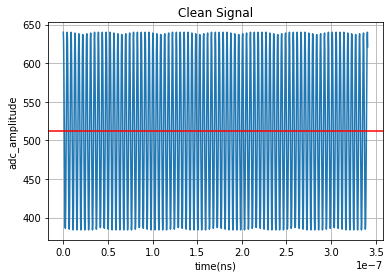

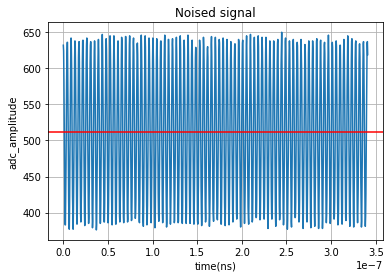

 Амплитуда -12 дБ 
 Частота 3229.0 Мгц 
 SNR 1 дБ


In [126]:
x = np.arange(0, window_size, tau)

make_plot(x,y_train[n_samples_train-1])
make_plot(x,x_train[n_samples_train-1], noised=1)

print(f' Амплитуда {amp[n_samples_train-1]} дБ \n Частота {np.round(freq[n_samples_train-1] * 1e-6)} Мгц \n SNR {snr[n_samples_train-1]} дБ')

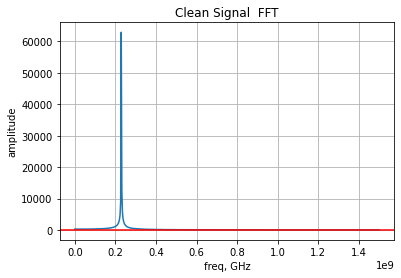

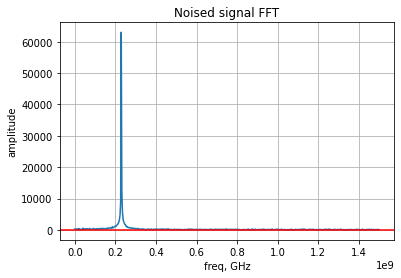

In [127]:
y_fft_yt = np.round(np.abs(np.fft.fft(y_train[n_samples_train-1] - adc_shift, N)))
make_plot_fft(x_fft, y_fft_yt[0:512])

y_fft_xt = np.round(np.abs(np.fft.fft(x_train[n_samples_train-1] - adc_shift, N)))
make_plot_fft(x_fft, y_fft_xt[0:512], noised=1)


In [128]:
x_train.shape

(10000, 1024)

Тренировочные данные созданы и проверены. Создадим тестовый датасет и можно приступать к построению и обучению сети.

In [129]:
n_samples_test = 2000

x_test, y_test, _, _, _ = make_dataset(n_sample = n_samples_test)

### Шаг 3: Сжимающий автокодировщик

Сначала создадим простой сжимающий автокодировщик переменной размерности.

In [130]:
def create_dense_ae(dim):
    # Размерность кодированного представления
    encoding_dim = dim

    # Энкодер
    # Входной плейсхолдер
    input_data= Input(shape=(N,)) # входной слой, принимает сэмпл из N отсчётов

    # Кодированное полносвязным слоем без использования активации
    encoded_3 = Dense(encoding_dim, activation='linear')(input_data)
    
    # Декодер
    # Раскодированное другим полносвязным слоем 
    input_encoded = Input(shape=(encoding_dim,))
    decoded_3 = Dense(N, activation='linear')(input_encoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    encoder = Model(input_data, encoded_3, name="encoder")
    decoder = Model(input_encoded, decoded_3, name="decoder")
    autoencoder = Model(input_data, decoder(encoder(input_data)), name="autoencoder")
    return encoder, decoder, autoencoder

Создадим экземпляр со схемой размерности 1024 -> 400 -> 1024

In [131]:
encoder, decoder, autoencoder = create_dense_ae(dim = 400)

autoencoder.compile(optimizer='adam', loss='MeanAbsoluteError', metrics='mse')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
encoder (Functional)         (None, 400)               410000    
_________________________________________________________________
decoder (Functional)         (None, 1024)              410624    
Total params: 820,624
Trainable params: 820,624
Non-trainable params: 0
_________________________________________________________________


Обучим наш автокодировщик

In [132]:
autoencoder.fit(y_train, y_train,
                epochs=200,
                batch_size=250,
                shuffle=True,
                validation_data=(y_test, y_test))

Epoch 1/200
40/40 [==============================] - 1s 31ms/step - loss: 143.3390 - mse: 54795.6719 - val_loss: 107.8841 - val_mse: 24684.4336
Epoch 2/200
40/40 [==============================] - 1s 29ms/step - loss: 85.9059 - mse: 20630.9336 - val_loss: 75.2194 - val_mse: 18991.2520
Epoch 3/200
40/40 [==============================] - 1s 29ms/step - loss: 74.3075 - mse: 18578.3125 - val_loss: 72.7788 - val_mse: 18313.6543
Epoch 4/200
40/40 [==============================] - 1s 29ms/step - loss: 73.5876 - mse: 17994.2578 - val_loss: 72.9165 - val_mse: 17885.4082
Epoch 5/200
40/40 [==============================] - 1s 29ms/step - loss: 73.1898 - mse: 17434.7852 - val_loss: 71.6900 - val_mse: 17316.7148
Epoch 6/200
40/40 [==============================] - 1s 29ms/step - loss: 72.7446 - mse: 16881.6992 - val_loss: 74.8142 - val_mse: 17197.9824
Epoch 7/200
40/40 [==============================] - 1s 29ms/step - loss: 70.7168 - mse: 16165.1025 - val_loss: 71.0911 - val_mse: 16383.4590
Epoc

Не самые впечатлющие результаты, но и степень сжатия достаточно велика. Отметим, что ошибка на валидационном наборе снижается очень слабо после первых 20 эпох, а её производная всё время меняет знак. В дальнейшем можно подстроить скорость обучения, чтобы получить оптимальную ошибку быстрее.

Пока что отрисуем графики на тестовом наборе.

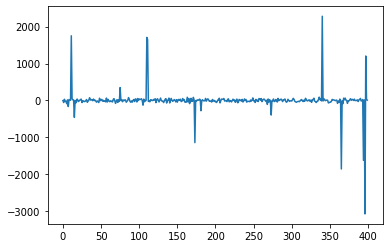

In [133]:
n = 10

data_test = y_test[:n]
encoded = encoder.predict(data_test, batch_size=n)
encoded[1]
plt.plot(encoded[1])


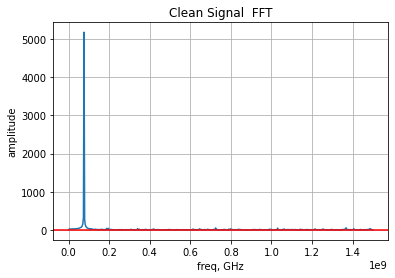

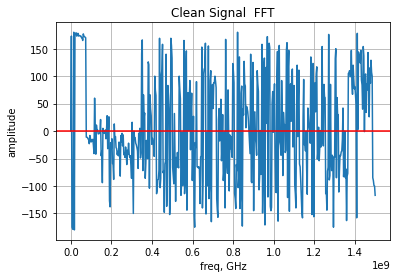

In [134]:
fft_encoded = np.round(np.abs(np.fft.fft(y_test[1] - np.mean(y_test[1]), N)))
fft_encoded_phase = np.round(np.angle(np.fft.fft(y_test[1] - np.mean(y_test[1]), N), deg=True))
make_plot_fft(x_fft, fft_encoded[0:512])
make_plot_fft(x_fft, fft_encoded_phase[0:512])

array([[787.2416 , 519.62213, 376.61203, ..., 322.56012, 400.6158 ,
        689.1099 ],
       [558.00946, 523.727  , 524.3454 , ..., 495.922  , 515.56616,
        499.54623],
       [587.9788 , 548.0543 , 548.184  , ..., 514.1395 , 571.315  ,
        477.37924],
       ...,
       [621.3387 , 539.8558 , 526.6463 , ..., 478.21042, 522.6335 ,
        479.5574 ],
       [711.7582 , 474.46063, 369.4048 , ..., 186.77745, 725.6625 ,
        387.27756],
       [642.6236 , 571.2997 , 586.11346, ..., 444.67242, 479.32327,
        420.19138]], dtype=float32)

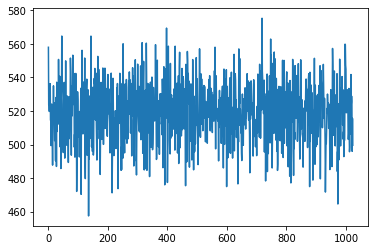

In [135]:
decoded = decoder.predict(encoded, batch_size=n)

plt.plot(decoded[1])
decoded

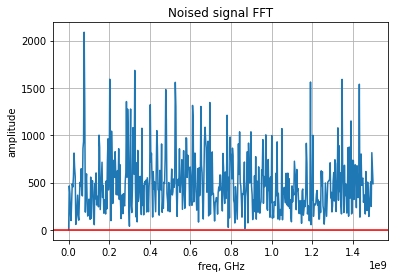

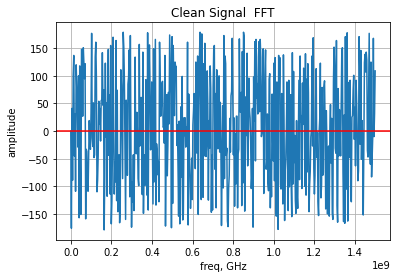

In [136]:
fft_decoded = np.round(np.abs(np.fft.fft(decoded[1] - np.mean(decoded[1]), N)))
fft_decoded_phase = np.round(np.angle(np.fft.fft(decoded[1] - np.mean(decoded[1]), N), deg=True))
make_plot_fft(x_fft, fft_decoded[0:512], noised=1)
make_plot_fft(x_fft, fft_decoded_phase[0:512])

Можно использовать этот подход для сжматия большого потока данных при передаче их через ограниченный по скорости канал связи. Однако SNR при этом уменьшается достаточно сильно, а фаза полностью уничтожена

### Шаг 4: Шумоподавляющий автокодировщик

Используем аналогичный подход к построению и переобучим автокодировщик из предыдущего раздела.

In [137]:
def create_denoising_model(dim):
  
  def add_noise(x):
    noise_factor = 5
    noise = K.random_normal([N,], 0, noise_factor)
    x = x + noise
    return x

      # Размерность кодированного представления
  encoding_dim = dim

      #Вход и выход шумного слоя
  input_data  = Input(shape=(N,))
  noised_data = Lambda(add_noise)(input_data)

    # Кодированное полносвязным слоем без использования активации
  encoded_3 = Dense(encoding_dim, activation='relu')(noised_data)
    
    # Декодер
    # Раскодированное другим полносвязным слоем 
  input_encoded = Input(shape=(encoding_dim,))
  decoded_3 = Dense(N, activation='linear')(input_encoded)
  


  noiser = Model(input_data, noised_data, name="noiser")

  encoder = Model(input_data, encoded_3, name="encoder")
  decoder = Model(input_encoded, decoded_3, name="decoder")
  autoencoder = Model(input_data, decoder(encoder(input_data)), name="autoencoder")

  denoiser_model = Model(input_data, autoencoder(noiser(input_data)), name="denoiser")

  return noiser, denoiser_model, encoder, decoder

In [138]:
noiser, denoiser_model, encoder_n, decoder_n = create_denoising_model(dim=1000)

hl = losses.Huber(delta=0.5)


denoiser_model.compile(optimizer='adam', loss='MeanAbsoluteError', metrics='mse')
denoiser_model.summary()

Model: "denoiser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
noiser (Functional)          (None, 1024)              0         
_________________________________________________________________
autoencoder (Functional)     (None, 1024)              2050024   
Total params: 2,050,024
Trainable params: 2,050,024
Non-trainable params: 0
_________________________________________________________________


In [139]:
denoiser_model.fit(y_train, y_train,
                   epochs=200,
                   batch_size=250,
                   shuffle=True,
                   validation_data=(y_test, y_test))

Epoch 1/200
50/50 [==============================] - 3s 60ms/step - loss: 106.7132 - mse: 31250.6973 - val_loss: 65.4527 - val_mse: 12840.9717
Epoch 2/200
50/50 [==============================] - 3s 58ms/step - loss: 66.7326 - mse: 12929.3086 - val_loss: 71.5900 - val_mse: 13193.6484
Epoch 3/200
50/50 [==============================] - 3s 57ms/step - loss: 66.5342 - mse: 12782.9170 - val_loss: 66.7985 - val_mse: 12810.0586
Epoch 4/200
50/50 [==============================] - 3s 57ms/step - loss: 65.0793 - mse: 12488.9492 - val_loss: 62.2125 - val_mse: 12153.0879
Epoch 5/200
50/50 [==============================] - 3s 58ms/step - loss: 66.2376 - mse: 12454.7832 - val_loss: 62.5227 - val_mse: 12102.9307
Epoch 6/200
50/50 [==============================] - 3s 57ms/step - loss: 61.9341 - mse: 11939.4932 - val_loss: 61.2864 - val_mse: 11865.4414
Epoch 7/200
50/50 [==============================] - 3s 57ms/step - loss: 62.7026 - mse: 11899.0596 - val_loss: 63.3620 - val_mse: 11886.1143
Epoch

In [140]:
n = 10

data_test = y_test[:n]
noised_data = noiser.predict(data_test, batch_size=n)
encoded_data = encoder_n.predict(noised_data[:n],  batch_size=n)
decoded_data = decoder_n.predict(encoded_data[:n], batch_size=n)



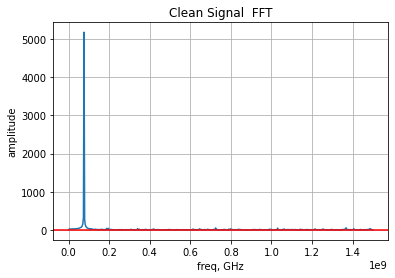

In [141]:
fft_data = np.round(np.abs(np.fft.fft(y_test[1] - np.mean(y_test[1]), N)))
make_plot_fft(x_fft, fft_data[0:512])

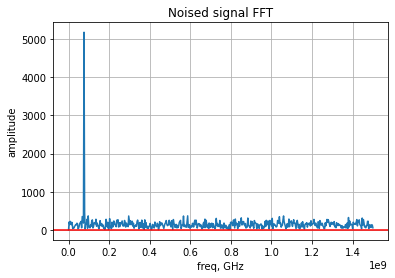

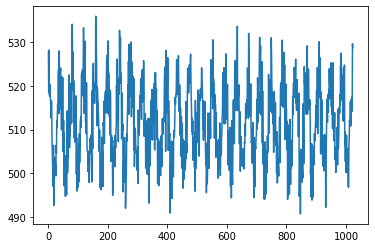

In [142]:
fft_noised = np.round(np.abs(np.fft.fft(noised_data[1] - np.mean(noised_data[1]), N)))
make_plot_fft(x_fft, fft_noised[0:512], noised=1)
plt.plot(noised_data[1])

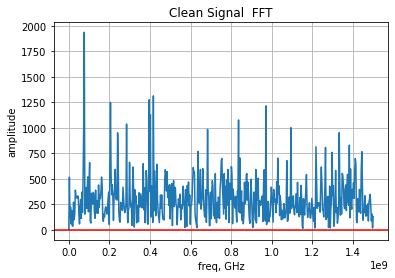

array([527.96375, 528.5853 , 528.0401 , ..., 519.9972 , 513.493  ,
       506.86874], dtype=float32)

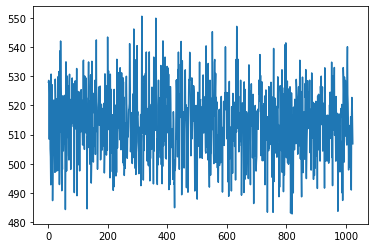

In [143]:
fft_decoded = np.round(np.abs(np.fft.fft(decoded_data[1] - np.mean(decoded_data[1]), N)))
make_plot_fft(x_fft, fft_decoded[0:512], noised=0)
plt.plot(decoded_data[1])
decoded_data[1]
